# LAS Demo

This is a demonstration of how `run_exp.py` works and the result of example config file.

## Notes :

    1. The goal is simply to reconstructed LAS and see if it works on TIMIT, all paremeters are NOT fine tuned.

    2. I run the experiment once with unassigned random seed and get the result.
    
    3. Run with smaller batch may help stablize testing performance. (but slowing down training process)
    
    4. The model trained on example config can be find in `checkpoint/`
    


## Package & Config setting

In [4]:
import yaml
from util.prepare_dataset import load_dataset,create_dataloader
from util.functions import log_parser
from model.las_model import Listener,Speller
import numpy as np
from torch.autograd import Variable
import torch
import time
import matplotlib.pyplot as plt
% matplotlib inline

# Load example config file for experiment
config_path = 'config/las_example_config.yaml'
conf = yaml.load(open(config_path,'r'))

# Parameters loading
num_epochs = conf['training_parameter']['num_epochs']
training_msg = 'epoch_{:2d}_step_{:3d}_TrLoss_{:.4f}_TrWER_{:.2f}'
epoch_end_msg = 'epoch_{:2d}_TrLoss_{:.4f}_TrWER_{:.2f}_TtLoss_{:.4f}_TtWER_{:.2f}_time_{:.2f}'
traing_log = open(conf['meta_variable']['training_log_dir']+conf['meta_variable']['experiment_name']+'.log','w')
listener_model_path = conf['meta_variable']['checkpoint_dir']+conf['meta_variable']['experiment_name']+'.listener'
speller_model_path = conf['meta_variable']['checkpoint_dir']+conf['meta_variable']['experiment_name']+'.speller'
verbose_step = conf['training_parameter']['verbose_step']
tf_rate_upperbound = conf['training_parameter']['tf_rate_upperbound']
tf_rate_lowerbound = conf['training_parameter']['tf_rate_lowerbound']


## Prepare Dataset 

In [3]:
# Load preprocessed TIMIT Dataset
# X : Padding to shape [num of sample, max_timestep, feature_dim]
# Y : Squeeze repeated label and apply one-hot encoding (preserve 0 for <sos> and 1 for <eos>)
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(**conf['meta_variable'])
train_set = create_dataloader(X_train, y_train, **conf['model_parameter'], **conf['training_parameter'], shuffle=True)
valid_set = create_dataloader(X_val, y_val, **conf['model_parameter'], **conf['training_parameter'], shuffle=False)
test_set = create_dataloader(X_test, y_test, **conf['model_parameter'], **conf['training_parameter'], shuffle=False)

## Construct Model

In [4]:
listener = Listener(**conf['model_parameter'])
speller = Speller(**conf['model_parameter'])
optimizer = torch.optim.Adam([{'params':listener.parameters()}, {'params':speller.parameters()}], 
                              lr=conf['training_parameter']['learning_rate'])

## Training Progress

In [ ]:
best_ler = 1.0

for epoch in range(num_epochs):
    epoch_head = time.time()
    tr_loss = 0.0
    tr_ler = []
    tt_loss = 0.0
    tt_ler = []

    # Teacher forcing rate linearly decay
    tf_rate = tf_rate_upperbound - (tf_rate_upperbound-tf_rate_lowerbound)*(epoch/num_epochs)
    
    # Training
    for batch_index,(batch_data,batch_label) in enumerate(train_set):
        batch_loss, batch_ler = batch_iterator(batch_data, batch_label, listener, speller, optimizer, 
                                               tf_rate, is_training=True, **conf['model_parameter'])
        tr_loss += batch_loss
        tr_ler.extend(batch_ler)
        if (batch_index+1) % verbose_step == 0:
            print(training_msg.format(epoch+1,batch_index+1,tr_loss[0]/(batch_index+1),sum(tr_ler)/len(tr_ler)),end='\r',flush=True)
    training_time = float(time.time()-epoch_head)
    
    # Testing
    for _,(batch_data,batch_label) in enumerate(test_set):
        batch_loss, batch_ler = batch_iterator(batch_data, batch_label, listener, speller, optimizer, 
                                               tf_rate, is_training=False, **conf['model_parameter'])
        tt_loss += batch_loss
        tt_ler.extend(batch_ler)

    # Logger
    print(epoch_end_msg.format(epoch+1,tr_loss[0]/(batch_index+1),sum(tr_ler)/len(tr_ler),
                               tt_loss[0]/len(test_set),sum(tt_ler)/len(tt_ler),training_time),flush=True)
    print(epoch_end_msg.format(epoch+1,tr_loss[0]/(batch_index+1),sum(tr_ler)/len(tr_ler),
                               tt_loss[0]/len(test_set),sum(tt_ler)/len(tt_ler),training_time),flush=True,file=traing_log)

    # Checkpoint
    if best_ler >= tt_loss[0]/len(test_set):
        best_ler = tt_loss[0]/len(test_set)
        torch.save(listener, listener_model_path)
        torch.save(speller, speller_model_path)



## Result


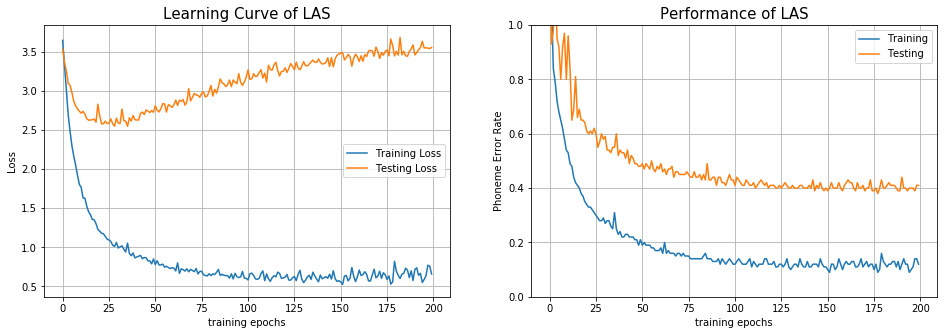

In [12]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
tr_loss, tt_loss, tr_ler, tt_ler = log_parser('log/smaller_batch.log')

axs[0].plot(tr_loss,label='Training Loss');axs[0].plot(tt_loss,label='Testing Loss');
axs[0].legend();axs[0].set_xlabel('training epochs');axs[0].set_ylabel('Loss');
axs[0].set_title('Learning Curve of LAS',size=15);axs[0].grid(True);
axs[1].plot(tr_ler,label='Training');axs[1].plot(tt_ler,label='Testing');axs[1].grid(True);
axs[1].legend();axs[1].set_xlabel('training epochs');axs[1].set_ylabel('Phoneme Error Rate');
axs[1].set_ylim(0,1)
axs[1].set_title('Performance of LAS',size=15)
plt.savefig('log/result.jpg')